## Notebook local ayant permis le debuggage

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import random
from PIL import Image

from pyspark.sql import SparkSession
from pyspark.sql.functions import split, udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

pd.set_option('display.max_colwidth', 250)

2022-10-14 22:26:03.007174: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-14 22:26:03.052878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 22:26:03.052953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Création d'une session spark
spark = SparkSession.builder.master("local[*]").appName("Fruits").getOrCreate()

spark.sparkContext.setLogLevel("OFF")

spark

22/10/07 11:16:06 WARN Utils: Your hostname, Franck-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.116 instead (on interface enxc025a5dc297d)
22/10/07 11:16:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 11:16:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Récupération des photos et création de la classe

In [3]:
# Récupération des images et création de leur classe (sur la base du nom du répertoire)
path = "./Donnees/fruits_360/Training/*"

t0 = time.time()

# Chargement des données
df_images = spark.read.format("image").load(path).toDF('image')

# Ajout d'une colonne avec le path pour récupérer la classe
df_images = df_images.withColumn("path", df_images.image.origin)
df_images = df_images.withColumn("path", split(df_images.path, '//')[1])  # Suppression de file:///

# Ajout d'une colonne pour la class
df_images = df_images.withColumn("classe", split(df_images.path, '/')[8])  # Suppression du chemin pour ne garder que  : apple_xxx
df_images = df_images.withColumn("classe", split(df_images['classe'], '_')[0]) # Conservation que du premier mot avant le '_'

df_images.show()

duree = time.time() - t0
print(duree)

+--------------------+--------------------+------+
|               image|                path|classe|
+--------------------+--------------------+------+
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/agent/Openc...| apple|
|{file:///home/age...|/home/age

In [4]:
df_images.select('image.height', 'image.width', 'image.nChannels', 'image.mode', 'image.data', 'classe').show(5)

+------+-----+---------+----+--------------------+------+
|height|width|nChannels|mode|                data|classe|
+------+-----+---------+----+--------------------+------+
|   890|  831|        3|  16|[FF FF FF FF FF F...| apple|
|   889|  834|        3|  16|[FF FF FF FF FF F...| apple|
|   889|  839|        3|  16|[FF FF FF FF FF F...| apple|
|   893|  833|        3|  16|[FF FF FF FF FF F...| apple|
|   893|  832|        3|  16|[FF FF FF FF FF F...| apple|
+------+-----+---------+----+--------------------+------+
only showing top 5 rows



## Affichage de 30 images d'un répertoire

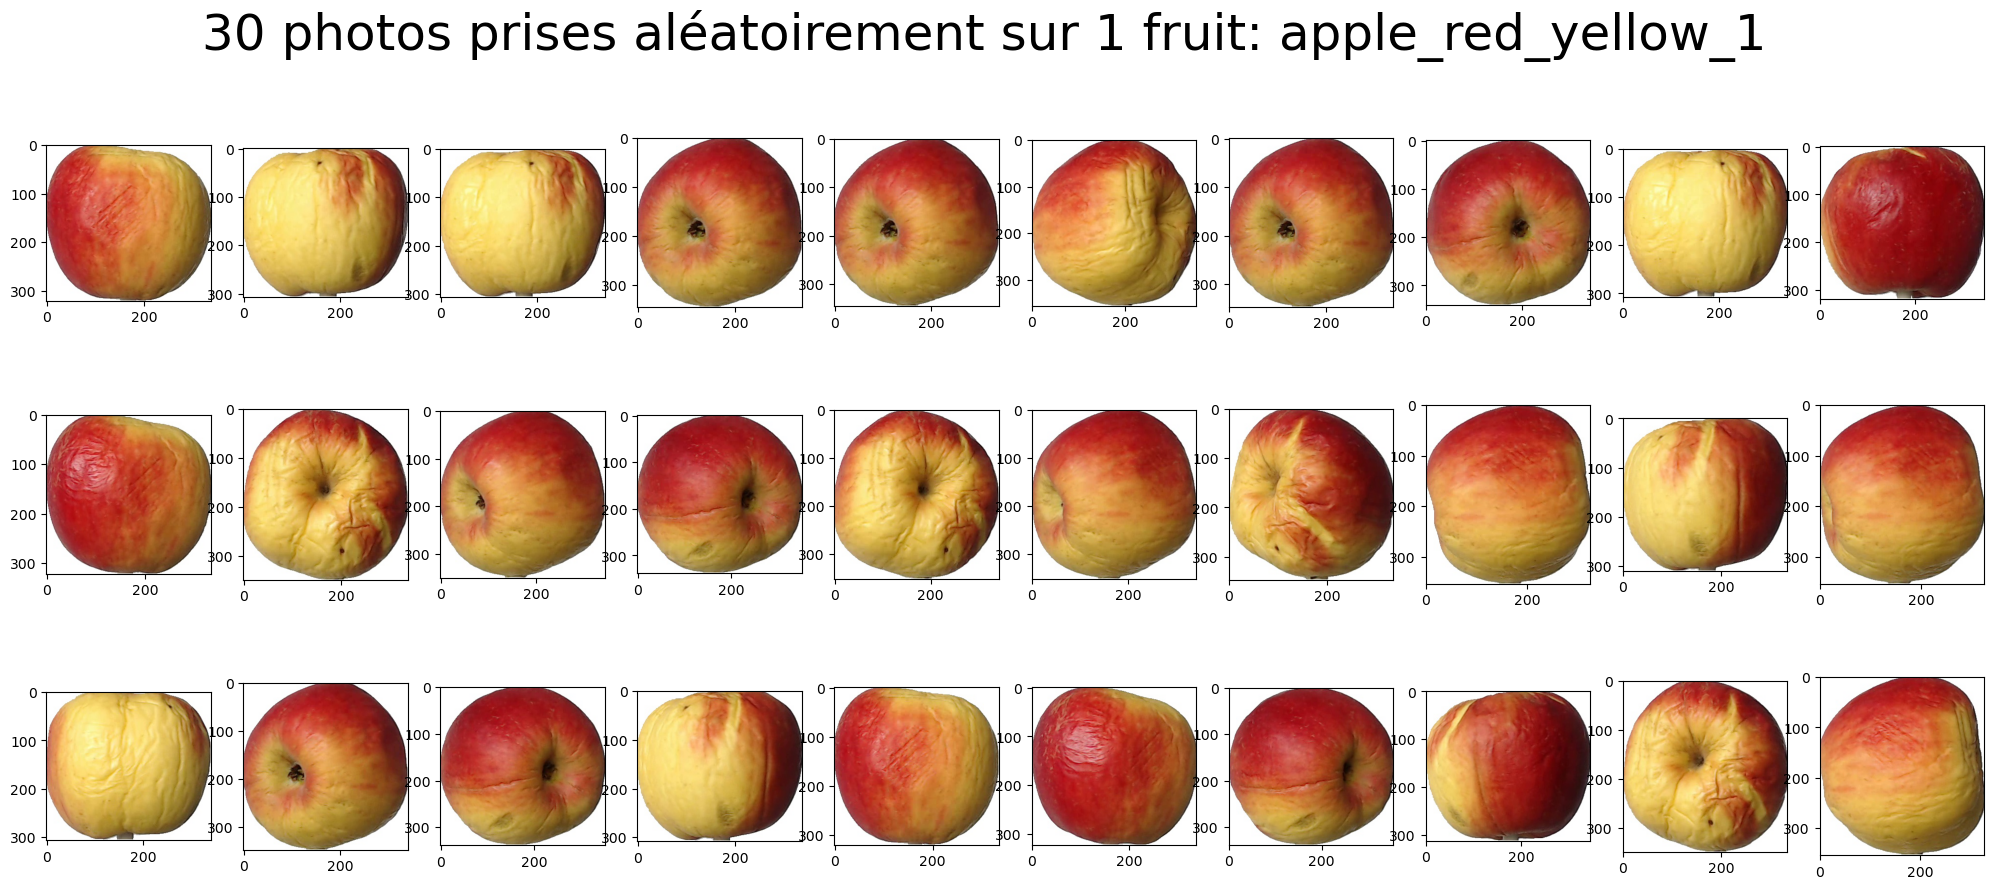

In [5]:
# Chemin test
path_test = "./data/fruits-360-original-size/Training/apple_red_yellow_1/*"

images = []
for f in glob.iglob(path_test):
    images.append(np.asarray(Image.open(f)))

# Sample de 30 images
images_30 = random.sample(images, 30)

fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(25, 10))

# flatten pour l'utilisation de imshow sur chaque axe
axs = axs.flatten()

# Itération sur les images, i servira d'index pour les axes
for i, file in enumerate(images_30):
    pic = Image.fromarray(file)
    axs[i].imshow(pic)

_ = fig.suptitle('30 photos prises aléatoirement sur 1 fruit: apple_red_yellow_1', fontsize=36)

## Transfer Learning

In [6]:
# Création du modèle avec suppression de la dernière couche et remplacement avec une couche de pooling

model_vgg = VGG16(weights="imagenet", include_top=False, pooling='max', input_shape=(224, 224, 3))
print(model_vgg.summary())

2022-10-07 11:16:44.060034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 11:16:44.127283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-07 11:16:44.127322: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-07 11:16:44.128660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# Sérialise le modèle pour une execution plus rapide
sc = spark.sparkContext
model_bc = sc.broadcast(model_vgg)

INFO:tensorflow:Assets written to: ram://611e9ce6-e96a-4676-9657-5f5742594210/assets


INFO:tensorflow:Assets written to: ram://611e9ce6-e96a-4676-9657-5f5742594210/assets


In [8]:
# Fonction de création des features VGG

def Creation_feature(path_image):
    image = img_to_array(load_img(path_image, target_size=(224, 224, 3))) # Charge l'image et la convertir en array
    image = np.expand_dims(image, axis=0)
    # image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))  # Reshape pour les besoins du modèle VGG - identique ligne au dessus
    image = preprocess_input(image) # Preprocessing pour les besoins du modèle (soustraction de la moyenne RGB du modèle d'entrainement)
    features = model_bc.value.predict(image,verbose=0) # .value car modèle sérialisé
    vector_feature = Vectors.dense(features.ravel().tolist())    
    return vector_feature

In [9]:
# Calcul des features et conservation dans une nouvelle colonne du df

t0 = time.time()

extract_features = udf(lambda x: Creation_feature(x), VectorUDT()) # UDF est la fonction spark de apply

df_image_features = df_images.withColumn('vgg16vec', extract_features('path')).select('path', 'classe', 'vgg16vec') # Ajout d'une colonne et conservation que de 3

df_image_features.show()
df_image_features.persist() # Pour le conserver en mémoire

print(time.time() - t0)

2022-10-07 11:16:49.835264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 11:16:50.286804: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 11:16:51.319497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-07 11:16:51.319617: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

+--------------------+------+--------------------+
|                path|classe|            vgg16vec|
+--------------------+------+--------------------+
|/home/agent/Openc...| apple|[83.4949722290039...|
|/home/agent/Openc...| apple|[91.5139999389648...|
|/home/agent/Openc...| apple|[86.4469680786132...|
|/home/agent/Openc...| apple|[105.054237365722...|
|/home/agent/Openc...| apple|[112.487655639648...|
|/home/agent/Openc...| apple|[118.911384582519...|
|/home/agent/Openc...| apple|[90.1322174072265...|
|/home/agent/Openc...| apple|[93.41845703125,3...|
|/home/agent/Openc...| apple|[68.2991180419921...|
|/home/agent/Openc...| apple|[113.235488891601...|
|/home/agent/Openc...| apple|[103.772010803222...|
|/home/agent/Openc...| apple|[89.7065658569336...|
|/home/agent/Openc...| apple|[118.284629821777...|
|/home/agent/Openc...| apple|[87.7155380249023...|
|/home/agent/Openc...| apple|[75.1771545410156...|
|/home/agent/Openc...| apple|[75.2293624877929...|
|/home/agent/Openc...| apple|[8

## Standardisation

In [10]:
# Standardisation des données
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='vgg16vec',
                              outputCol='features_scaled')
std = standardizer.fit(df_image_features)
df_image_std = std.transform(df_image_features)
df_image_std = df_image_std.select('path', 'classe', 'features_scaled')

2022-10-07 11:17:05.554906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 11:17:05.617324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 11:17:05.974170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [11]:
df_image_std.count()

6231

In [12]:
df_image_std.show()

+--------------------+------+--------------------+
|                path|classe|     features_scaled|
+--------------------+------+--------------------+
|/home/agent/Openc...| apple|[1.69882340464837...|
|/home/agent/Openc...| apple|[2.04023629604939...|
|/home/agent/Openc...| apple|[1.82450565377778...|
|/home/agent/Openc...| apple|[2.61671660978910...|
|/home/agent/Openc...| apple|[2.93319697594892...|
|/home/agent/Openc...| apple|[3.20668946796734...|
|/home/agent/Openc...| apple|[1.98140642458478...|
|/home/agent/Openc...| apple|[2.12131921856113...|
|/home/agent/Openc...| apple|[1.05185463200633...|
|/home/agent/Openc...| apple|[2.96503623652635...|
|/home/agent/Openc...| apple|[2.56212536831096...|
|/home/agent/Openc...| apple|[1.96328416191516...|
|/home/agent/Openc...| apple|[3.18000516622855...|
|/home/agent/Openc...| apple|[1.87851546007499...|
|/home/agent/Openc...| apple|[1.34468942610193...|
|/home/agent/Openc...| apple|[1.34691219757848...|
|/home/agent/Openc...| apple|[1

## PCA

In [13]:
# Réduction de dimensions
t0 = time.time()

pca = PCA(k=512, inputCol="features_scaled", outputCol="Features_PCA")
pca_model = pca.fit(df_image_std)

result = pca_model.transform(df_image_std).select("Features_PCA")

result.show()

print(time.time() - t0)

+--------------------+
|        Features_PCA|
+--------------------+
|[7.45310448737081...|
|[6.92074933066340...|
|[8.75177111294207...|
|[9.82021507760009...|
|[7.81707413201804...|
|[6.83754209743231...|
|[8.24887887975044...|
|[6.83561079990664...|
|[7.98444010571091...|
|[6.65396377033979...|
|[7.20366755380273...|
|[6.84660666227335...|
|[7.38259252945461...|
|[8.34882286140108...|
|[6.79613685302335...|
|[6.85297900024436...|
|[6.53448067609765...|
|[6.2963751949165,...|
|[7.08765130464864...|
|[6.07105367712278...|
+--------------------+
only showing top 20 rows

6.1280224323272705


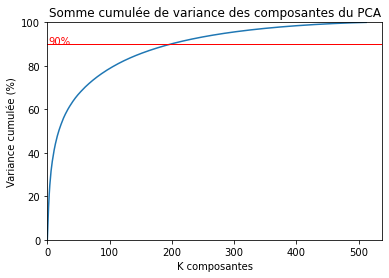

In [14]:
# Calcul du % de variance expliqué par la PCA
var = pca_model.explainedVariance.cumsum()
sns.lineplot(x=[i for i in range(512+1)], 
             y=np.insert(var, 0, 0)*100)
plt.title('Somme cumulée de variance des composantes du PCA')
plt.xlabel('K composantes')
plt.ylabel('Variance cumulée (%)')
plt.ylim(0, 100)
plt.xlim(left=0)
plt.axhline(90, lw=1, c='red')
plt.text(1, 90, '90%', c='red')
plt.show()

## Vérification pertinence VGG

In [15]:
df = result.toPandas()

# Récupération des valeurs pour les 2 premiers axes de la PCA
df['x'] = df['Features_PCA'].apply(lambda x : x[0])
df['y'] = df['Features_PCA'].apply(lambda x : x[1])

# Ajout de la classe
classe = df_images.select('classe').toPandas()
df['classe'] = classe.classe

<AxesSubplot:xlabel='x', ylabel='y'>

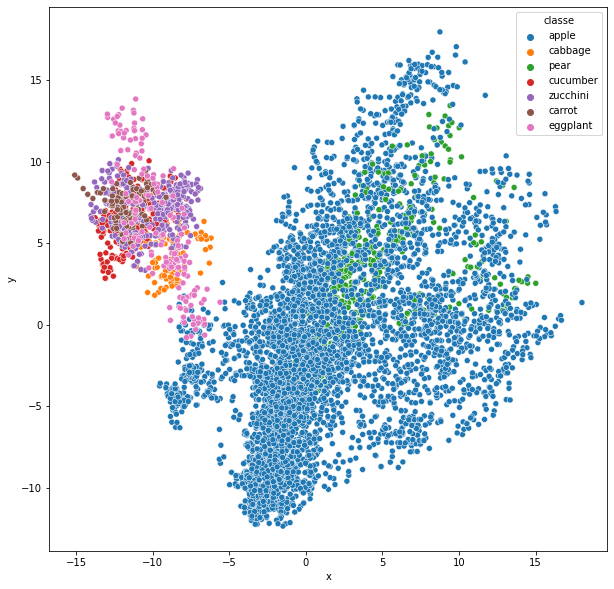

In [16]:
# Visualisation de la projection sur le premier plan de la PCA

plt.figure(figsize=(10, 10))
sns.scatterplot(x='x', y='y', data=df, hue=df['classe'])

Nous observons que les pommes et les poires sont plutôt bien différenciées. La forme a donc une influence prépondérente en sortie de VGG